# Titanic survival

### Who will make it?


This notebook is prepared for training purpose.

We will explore the [Titanic survival data](https://www.kaggle.com/c/titanic) , and model the survival with decision trees.
(see [Decision Tree course](https://www.linkedin.com/learning/machine-learning-ai-foundations-decision-trees))

## 1. GOALS

 - predict survival rate of titanic passengers
 - practice decision trees
 - build a small data science project


## 2. Data understanding



In [9]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv("Titanic/train.csv")
print(data.info())
print("\n Embarked options: ", data["Embarked"].value_counts())

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None

 Embarked options:  S    644
C    168
Q     77
Name: Embarked, dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Apply less memory-consuming data types to the data (see [Dataquest blog](https://www.dataquest.io/blog/pandas-big-data/))

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# setting up new data types
dtypes_col       = data.columns
dtypes_type_old  = data.dtypes
dtypes_type      = ['int16', 'bool','category','object','category','float32','int8','int8','object','float32','object','category']
optimized_dtypes = dict(zip(dtypes_col, dtypes_type))

#read data once again with optimized columns
data_optimized = pd.read_csv("Titanic/train.csv",dtype=optimized_dtypes)

print(data_optimized.info())
data_optimized.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int16
Survived       891 non-null bool
Pclass         891 non-null category
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float32
SibSp          891 non-null int8
Parch          891 non-null int8
Ticket         891 non-null object
Fare           891 non-null float32
Cabin          204 non-null object
Embarked       889 non-null category
dtypes: bool(1), category(3), float32(2), int16(1), int8(2), object(3)
memory usage: 35.2+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.099998,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050000,NaN,S


<span style="color:green"> Hooray! We saved more than half of the memory and the table is read properly!</span>

## Do we have any missing data?

In [4]:
data_optimized.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

"Cabin" column will not be interesting for us, because there is a lot of missing data.
"Age" column may be important for the model, and but some of decision tree models have a mechanism for estimating missing value based on correlation with other values if possible.

I will use [Kaggle, Anisotropic profile](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) to get the data analysis step by step.

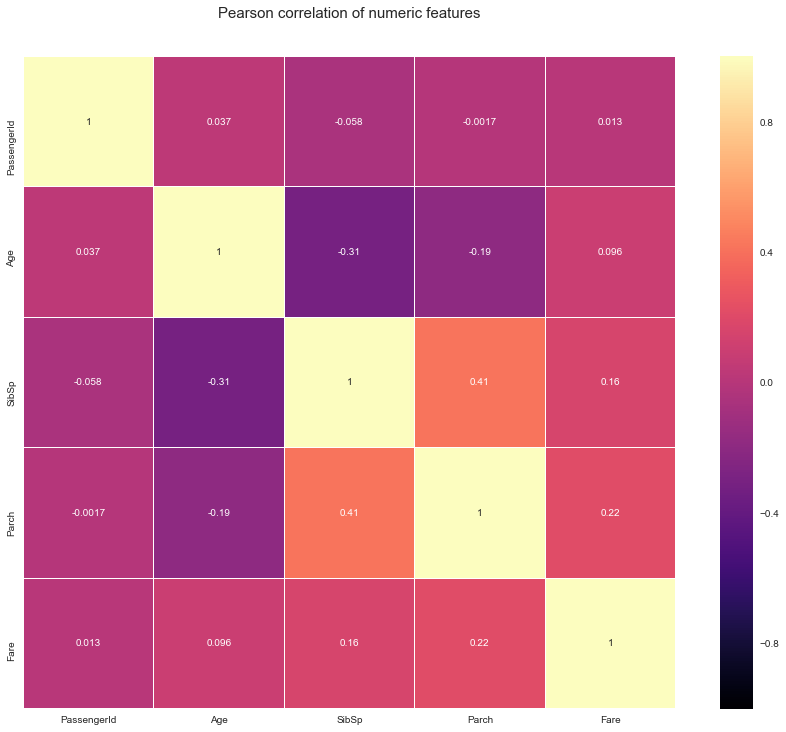

In [18]:
#numerical features

train_numeric = data_optimized.select_dtypes(include=['float32','int16','int8'])

colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of numeric features', y=1.05, size=15)
sns.heatmap(train_numeric.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Two interesting correlations are:
 - positive (0.41) for "SibSp" and "Parch"
 - negative  (-0.31) for "SibSp" and "Age"

In [ ]:
# binary features

In [ ]:
# category features

## 3. Data manipulation

## 4. Modelling

## 5. Evaluation

## 6. Conclusion